In [11]:
# %matplotlib notebook # comment this line when working in VSCode
import aipy, uvtools
import numpy as np
import pylab as plt
import random
import math
import os.path
import h5py
from jupyterthemes import jtplot
jtplot.style(theme='chesterish')
import pandas as pd
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

from tensorflow.keras.layers.experimental import preprocessing

from hera_sim import foregrounds, noise, sigchain, rfi, simulate
from sklearn.preprocessing import MinMaxScaler, StandardScaler

2.4.0


/anaconda3/lib/python3.6/site-packages/hera_sim/visibilities/__init__.py:22: UserWarning: HealVis failed to import.
  warnings.warn("HealVis failed to import.")
/anaconda3/lib/python3.6/site-packages/hera_sim/visibilities/__init__.py:27: UserWarning: PRISim failed to import.
  warnings.warn("PRISim failed to import.")
/anaconda3/lib/python3.6/site-packages/hera_sim/visibilities/__init__.py:33: UserWarning: VisGPU failed to import.
  warnings.warn("VisGPU failed to import.")
/anaconda3/lib/python3.6/site-packages/hera_sim/__init__.py:36: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next major release will involve modifications to the package's API, which move toward a regularization of the wa

# Generate visibility plot

In [12]:
'''
Generate one visibility
'''
def generate_vis(lsts, fqs, bl_len_ns):
    # point-source and diffuse foregrounds
    vis = foregrounds.pntsrc_foreground(lsts, fqs, bl_len_ns, nsrcs=200)
    Tsky_mdl = noise.HERA_Tsky_mdl['xx']
    vis += foregrounds.diffuse_foreground(lsts, fqs, bl_len_ns, Tsky_mdl)

    # noise
#     tsky = noise.resample_Tsky(fqs,lsts,Tsky_mdl=noise.HERA_Tsky_mdl['xx'])
#     t_rx = 150.
#     OMEGA_P = (0.72)*np.ones(1024)
#     nos_jy = noise.sky_noise_jy(tsky + t_rx, fqs, lsts, OMEGA_P)
#     vis += nos_jy
    
    # crosstalk, gains
    xtalk = sigchain.gen_whitenoise_xtalk(fqs)
    g = sigchain.gen_gains(fqs, [1,2,3])
    vis = sigchain.apply_xtalk(vis, xtalk)
    vis = sigchain.apply_gains(vis, g, (1,2))

    return vis

'''
Plot one visibility
MX is max value of color scale in the plot
DRNG = MX - min value of color scale in the plot
'''
def plot_one_vis(vis, ylim, MX, DRNG, figsize):
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
      
    fig.sca(ax1)
    uvtools.plot.waterfall(vis, mode='log', mx=MX, drng=DRNG)
    plt.colorbar(label=r"Amplitude [log$_{10}$(V/Jy)]")
    plt.ylim(0,ylim)

    fig.sca(ax2)
    uvtools.plot.waterfall(vis, mode='phs')
    plt.colorbar(label="Phase [rad]")
    plt.ylim(0,ylim)
    plt.xlabel("Frequency channel")

    fig.text(0.02, 0.5, 'LST [rad]', ha='center', va='center', rotation='vertical')

<class 'numpy.ndarray'>
(1500, 1024)


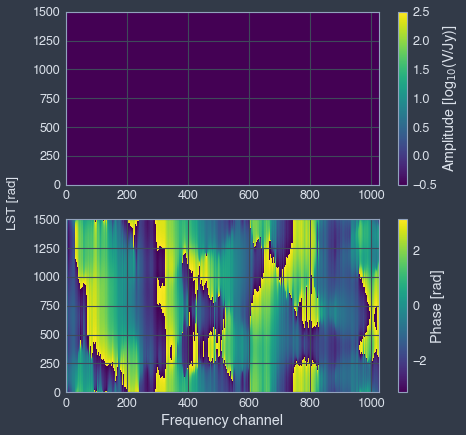

In [13]:
lsts = np.linspace(1, 0.5*np.pi, 1500, endpoint=False) # local sidereal times; start range, stop range, number of snapshots
# 1500 to match the mask; π/2 ~ 6h
fqs = np.linspace(.1, .2, 1024, endpoint=False) # frequencies in GHz; start freq, end freq, number of channels
bl_len_ns = np.array([30.,0,0]) # ENU coordinates

vis = generate_vis(lsts, fqs, bl_len_ns)
print(type(vis))
print(vis.shape)
plot_one_vis(vis, 1500, 2.5, 3, (7,7))
# uvtools.plot.waterfall?

In [14]:
# foregrounds.pntsrc_foreground?
# print(type(vis[120][555]))
# mask[120][555]

# RFI mask
This is a boolean mask: `True` = RFI, `False` = no RFI

Parameters:
- 6 hours in JD, 1500 units
  - times match: using range π/2 for lsts in vis plot, with 1500 snapshots
- 1024 channels, 100-200 MHz

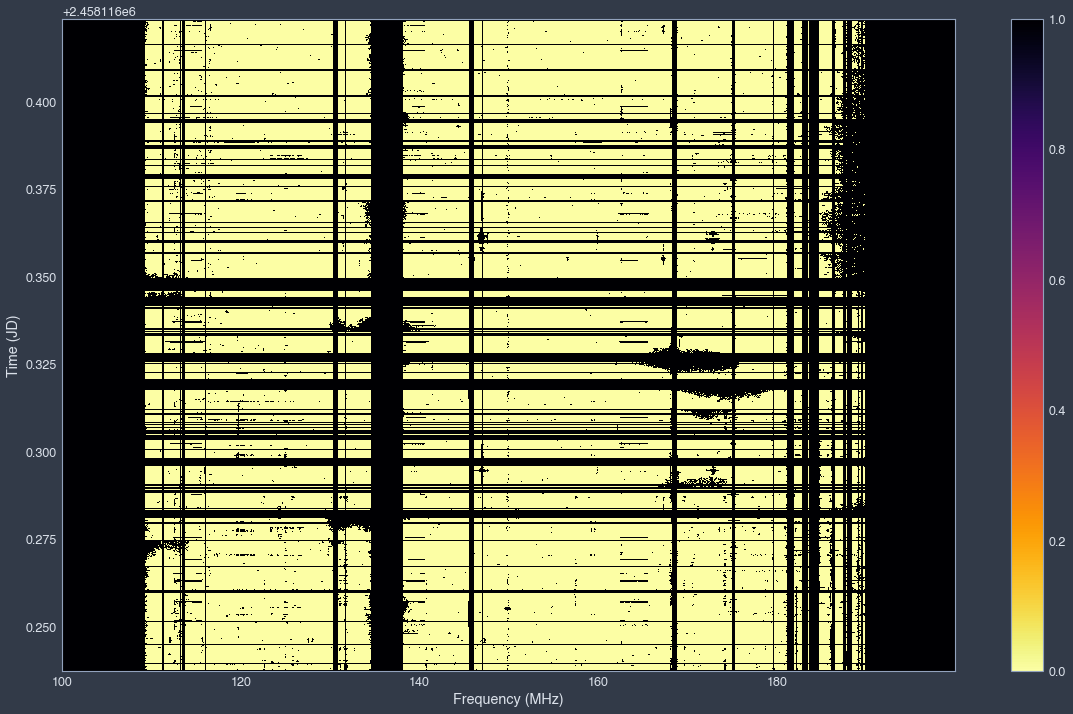

(1500, 1024)


In [51]:
f = h5py.File("mask_HERA.hdf5", "r")
plt.figure(figsize=(20,12))
mask = f['mask']
plt.imshow((mask[()]), cmap='inferno_r', aspect='auto',
           origin='lower', vmin=0, vmax=1,
           extent=(f['axes']['frequency'][0]/1e6,f['axes']['frequency'][-1]/1e6,
                  f['axes']['time'][0], f['axes']['time'][-1]))
plt.xlabel('Frequency (MHz)')
plt.ylabel('Time (JD)')
plt.grid()
plt.colorbar()
plt.show()
print(mask.shape)

### Generate custom mask

Take horizontal or vertical pixel slice of the mask. Spans of the `True` sections = spans of RFI

In [54]:
'''
Get RFI spans from one row/col
'''
def get_RFI_spans(row):
    spans = [(key, sum(1 for _ in group)) for key, group in itertools.groupby(row)]
    ############## ask Adrian ##############
#     spans = spans[1:-1] # remove first and last element of mask? 
    if len(spans) == 1:
        raise Exception("Error: all values in the row/col are True; select another one")
    return spans

rfi_widths = get_RFI_spans(mask[1434])
rfi_heights = get_RFI_spans(mask[:,166])

# print("RFI widths", rfi_widths)
# print("RFI heights", rfi_heights)

Generate randomized mask from spans

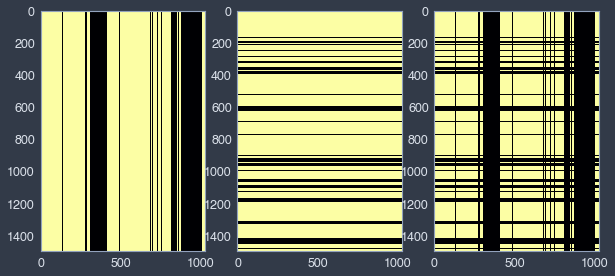

In [72]:
def plot_mask(mask, mask2, mask3):
    plt.figure(figsize=(10,10))
    plt.subplot(1, 3, 1)
    plt.grid(False)
    plt.imshow(mask, cmap='inferno_r') # black is RFI
    plt.subplot(1, 3, 2)
    plt.grid(False)
    plt.imshow(mask2, cmap='inferno_r')
    plt.subplot(1, 3, 3)
    plt.grid(False)
    plt.imshow(mask3, cmap='inferno_r')

'''
Generate random RFI mask with dimensions time x freq, given RFI spans from a real mask
'''
def generate_random_mask(time, freq, widths, heights):
    random.shuffle(widths)
    random.shuffle(heights)
    
    # row by row
    one_row = []
    for w in widths:
        one_row.extend([w[0]] * w[1])
    mask = np.tile(one_row, (time, 1)) # copy one_row `time` times in the vertical direction
#     print(mask.shape)
#     print(widths)
    
    # col by col
    one_col = []
    for w in heights:
        one_col.extend([w[0]] * w[1])
    mask2 = np.tile(np.array(one_col).reshape((time, 1)), (1, freq))
#     print(mask2.shape)
    
    combined_mask = np.logical_or(mask, mask2) # any cell with True will have RFI
    plot_mask(mask, mask2, combined_mask)
    return combined_mask
    


custom_mask = generate_random_mask(1500, 1024, rfi_widths, rfi_heights)

### Apply mask to visibility (doesn't work yet)

In [7]:
# vis_new = vis[mask]
# print(vis_new.shape)
# plot_one_vis(vis_new, 1500, 2.5, 3)

# Create dataset

In [8]:
# labelled_data = []
# for x in range(mask.shape[0]):
#     for y in range(mask.shape[1]):
#         if mask[x][y] == False: # no RFI
#             labelled_data.append([x, y, vis[x][y]])
#         else:
#             masked.append([x, y, vis[x][y]])

# df = pd.DataFrame(labelled_data, columns=["Time", "Freq", "Vis"])
# df.to_csv("labelled_data.csv")


# df2 = pd.DataFrame(masked, columns=["Time", "Freq", "Vis"])
# df2.to_csv("masked.csv")


# df.head()

In [39]:
df = pd.read_csv("labelled_data.csv", index_col=0)
df['Vis'] = df['Vis'].apply(lambda x: np.complex128(x)) # Import vis as complex numbers
# df2 = pd.read_csv("masked.csv", index_col=0)
# df2['Vis'] = df2['Vis'].apply(lambda x: np.complex128(x)) # Import as complex numbers
df.head()

,Time,Freq,Vis
0,2,96,0.012423+0.022791j
1,2,97,0.074763+0.101038j
2,2,98,0.008350+0.080610j
3,2,99,0.040928+0.125979j
4,2,100,0.126416+0.200326j


In [40]:
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

In [41]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop("Vis")
test_labels = test_features.pop("Vis")

type(train_labels[0])

numpy.complex128

In [42]:
# Normalize
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))

# ML model

In [47]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['mae','acc'])
  return model

In [48]:
model = build_and_compile_model(normalizer)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 2)                 5         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 4,422
Trainable params: 4,417
Non-trainable params: 5
_________________________________________________________________


In [49]:
%%time
history = model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=1, epochs=100)

Epoch 1/100
16257/16257 [==============================] - 36s 2ms/step - loss: 0.1188 - mae: 0.1188 - acc: 0.0000e+00 - val_loss: 0.1171 - val_mae: 0.1171 - val_acc: 0.0000e+00
Epoch 2/100
16257/16257 [==============================] - 38s 2ms/step - loss: 0.1171 - mae: 0.1171 - acc: 0.0000e+00 - val_loss: 0.1168 - val_mae: 0.1168 - val_acc: 0.0000e+00
Epoch 3/100
16257/16257 [==============================] - 35s 2ms/step - loss: 0.1169 - mae: 0.1169 - acc: 0.0000e+00 - val_loss: 0.1165 - val_mae: 0.1165 - val_acc: 0.0000e+00- mae: 0
Epoch 4/100
16257/16257 [==============================] - 35s 2ms/step - loss: 0.1167 - mae: 0.1167 - acc: 0.0000e+00 - val_loss: 0.1166 - val_mae: 0.1166 - val_acc: 0.0000e+00
Epoch 5/100
16257/16257 [==============================] - 45s 3ms/step - loss: 0.1167 - mae: 0.1167 - acc: 0.0000e+00 - val_loss: 0.1164 - val_mae: 0.1164 - val_acc: 0.0000e+00
Epoch 6/100
16257/16257 [==============================] - 36s 2ms/step - loss: 0.1166 - mae: 0.1166 -

16257/16257 [==============================] - 2532s 156ms/step - loss: 0.1163 - mae: 0.1163 - acc: 0.0000e+00 - val_loss: 0.1165 - val_mae: 0.1165 - val_acc: 0.0000e+00
Epoch 92/100
 8857/16257 [===============>..............] - ETA: 19s - loss: 0.1165 - mae: 0.1165 - acc: 0.0000e+00

KeyboardInterrupt: 

In [51]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

NameError: name 'history' is not defined

In [ ]:
f.close()